In [2]:
# Essentials for training and env

# For NN
import torch 
import torch.nn as nn 
import torch.functional as F
import torch.optim as optim

# For math computations
import numpy as np

# For random
import random 

# For envs
import gymnasium

# structure to save transitions 
from collections import namedtuple , deque
Transition = namedtuple("Transition",["state","action","next_state","reward"])

In [3]:
# For plots
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

# For saving files
from datetime import datetime

# for model vizualisation 
from torchsummary import summary

In [4]:
class ReplayMemory():
    def __init__(self,maxlen : int):
        self.memory_ = deque(maxlen=maxlen)

    def push(self,x : Transition):
        self.memory_.append(x)

    def sample(self,batch_size : int) -> list[Transition]:
        return random.sample(self.memory_,batch_size)
    
    def clear(self):
        return self.memory_.clear()
    
    def __len__(self):
        return len(self.memory_)

In [5]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN,self).__init__()
        nb = 50
        self.network = nn.Sequential(
            nn.Linear(2,nb),
            nn.ReLU(),

            nn.Linear(nb,nb),
            nn.ReLU(),

            nn.Linear(nb,4),
        )

    def forward(self,x):
        return self.network(x)
    
    def save(self,filename : str = None):
        if (filename == None):
            filename = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        torch.save(self.state_dict(),filename)

    def load(self,filename : str):
        self.load_state_dict(torch.load(filename, weights_only=True))

In [6]:
class Env():
    def __init__(self):
        env_name = "CliffWalking-v0"
        # Caractérisent l'environement actuel 
        self.env = gymnasium.make(env_name,render_mode="rgb_array")
        self.done = False
        self.state_gym,_ = self.env.reset()

        # Décrit le model actuel
        self.model = DQN()

        # Décrit les transitions observées jusqu'à présent
        self.memory = ReplayMemory(10000)

    # On définit un état comme étant un batch de taille 1 ou None
    def state(self):
        if (self.state_gym == None or self.done) :
            return None
        else :
            y = self.state_gym//12
            x = self.state_gym % 12
            return torch.tensor([[x,y]],dtype=torch.float)

    def show_state(self):
        img = self.env.render()
        plt.imshow(img)
        plt.axis("off")
        display.clear_output(wait=True)
        plt.show()

    # Relance le jeu
    def reset(self):
        self.state_gym , _ = self.env.reset()
        self.done = False
    
    # Calcule la longueur d'un plus court chemin entre state et goal (sous forme d'un flotant)
    def dist(state):
       goal = torch.tensor([[11,3]],dtype=torch.float)
       start = torch.tensor([[0,3]],dtype=torch.float)
       if (torch.equal(state,start)):
           return torch.tensor(13,dtype=torch.float)
       else :
           return torch.sum(torch.abs(state-goal))
       
    # 0: Move up
    # 1: Move right
    # 2: Move down
    # 3: Move left   
    # Fais un pas depuis l'état actuel via l'action donnée et renvoit la transition observéex
    # Une action est un tenseur contenant un seul scalaire
    def step(self,action : torch.tensor) :
        if (self.done):
            raise(ValueError("Trying to move from a final state"))

        prev_state = self.state()

        # do the step and update the new gym state
        self.state_gym,_,terminated,truncated,_ = self.env.step(action.item())
        self.done = terminated or truncated or (self.state_gym == 36)

        next_state = self.state()

        # tomber dans le trou ou revenir au point de départ est considéré comme une fin de partie
        if (truncated or (self.state_gym == 36)) :
            reward = -10
        # arriver au cookie est considéré comme une victoire et une fin de partie
        elif (terminated) :
            reward = 10
        # si on ne s'est pas rapproché de l'objectif on est pénalisé
        elif (Env.dist(prev_state) <= Env.dist(next_state)) :
            reward = -2
        else :
            reward = 1

        normalizer = 24
        reward = torch.tensor(reward/normalizer,dtype=torch.float).reshape((1,1))
        action = torch.tensor(action.item()).reshape((1,1))

        transition = Transition(prev_state, action, next_state , reward)
        return transition
    
    def policy(self):
        if (self.done):
            raise(ValueError("Trying to predict a move from a final state"))
        return self.model(self.state()).max(1).indices.reshape((1,1))
    
    def random_action(self) -> torch.tensor :
        if (self.done):
            raise(ValueError("Trying to sample a move from a final state"))
        action = random.randint(0,3)
        return torch.tensor(action).reshape((1,1))

In [7]:
def optimize(env : Env,optimizer,criterion,batch_size,discount_factor):
    if (len(env.memory) < batch_size) :
        return 

    # A list of batch_size transtions
    transition = env.memory.sample(batch_size)

    # A tuple with four coordinates : 
    # state -> a batch of size batch_size of states 
    # action -> a batch of size batch_size of actions
    # ect
    batch = Transition(*zip(*transition))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Batch of size batch_size of the Qvalue predicted by our current model, for the state and action of a transtion
    predicted = env.model(state_batch).gather(1,action_batch)

    next_state_value = torch.zeros((batch_size,1))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool )
    if non_final_mask.any():
        non_final_next_state = torch.cat([s for s in batch.next_state if s is not None])
        with torch.no_grad():
            next_state_value[non_final_mask] = env.model(non_final_next_state).max(1).values.unsqueeze(1)

    expected = reward_batch + (discount_factor * next_state_value)

    optimizer.zero_grad()
    loss = criterion(predicted,expected)
    loss.backward()
    torch.nn.utils.clip_grad_value_(env.model.parameters(), 100)
    optimizer.step()

In [8]:
def optimize_weak(env : Env,optimizer,criterion,batch_size,discount_factor):
    if (len(env.memory) < batch_size) :
        return 

    # A list of batch_size transtions
    transition = env.memory.sample(batch_size)

    # A tuple with four coordinates : 
    # state -> a batch of size batch_size of states 
    # action -> a batch of size batch_size of actions
    # ect
    batch = Transition(*zip(*transition))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)

    # Batch of size batch_size of the Qvalue predicted by our current model, for the state and action of a transtion
    predicted = env.model(state_batch).gather(1,action_batch)

    expected =  torch.zeros((batch_size,1))
    for i in range(batch_size):
        t = transition[i]
        with torch.no_grad() :
            if (t.next_state == None) :
                expected[i] = t.reward
            else :
                expected[i] = t.reward + discount_factor * env.model(t.next_state).max(1).values.item()

    optimizer.zero_grad()
    loss = criterion(predicted,expected)
    loss.backward()
    torch.nn.utils.clip_grad_value_(env.model.parameters(), 100)
    optimizer.step()

In [9]:
def optimizer_one_by_one(env,transition,optimizer,criterion,discount_factor):
        predicted_value = env.model(transition.state)[0][transition.action[0][0]]
        with torch.no_grad() :
            if (transition.next_state == None) :
                expected_value = transition.reward
            else :
                expected_value = transition.reward + discount_factor * env.model(transition.next_state).max(1).values.item()

        optimizer.zero_grad()
        loss = criterion(predicted_value,expected_value)
        loss.backward()
        torch.nn.utils.clip_grad_value_(env.model.parameters(), 100)
        optimizer.step()

In [10]:
def training(env):
    #env.model.load(filename)
    filename =  "saved_model/"  + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

    # Hyperparameters
    batch_size = 32
    epochs = 600
    max_episode_duration = 30
    epsilon_max = 1
    epsilon_min = 0.01
    epsilon_decay = 50.
    lr = 1e-4
    discount_factor = 0.9
    optimizer = optim.AdamW(env.model.parameters(), lr=lr, amsgrad=True)
    criterion = nn.SmoothL1Loss()

    env.memory.clear()
    reward_history = []

    for i in range(epochs):
        env.reset()
        epsilon = epsilon_min + (epsilon_max-epsilon_min)*np.exp(-i/epsilon_decay)
        it_counter = 0
        reward = 0
        while(not(env.done) and it_counter < max_episode_duration):
            it_counter += 1
            # Chose an action
            if (random.random() <= epsilon):
                action = env.random_action()
            else:
                with torch.no_grad() :
                    action = env.policy()

            # Apply the transition and save it in memory
            transition = env.step(action)
            reward += (transition.reward).item()
            env.memory.push(transition)
            
            # Optimize the model according to the observed reward
            #optimizer_one_by_one(env,transition,optimizer,criterion,discount_factor)
            optimize(env,optimizer,criterion,batch_size,discount_factor)
            #optimize_weak(env,optimizer,criterion,batch_size,discount_factor)

        normalizer = 24
        reward_history.append(reward*normalizer)

    window = 20*[1/20]
    reward_history = np.convolve(reward_history, window ,  mode="valid")
    plt.plot(reward_history)
    plt.show()

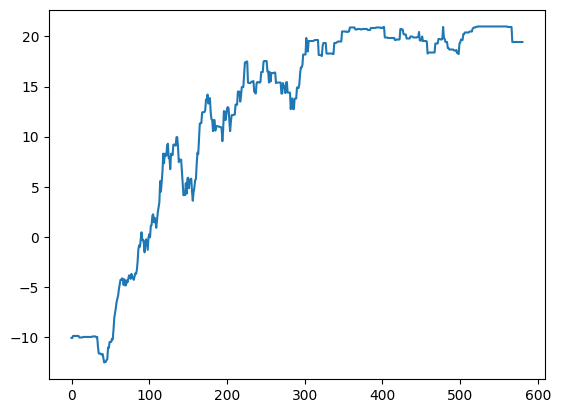

In [11]:
seed = 861
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

env= Env()
#print(summary(env.model, input_size= (1,2) ))
training(env)

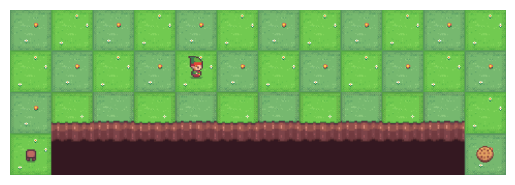

KeyboardInterrupt: 

In [12]:
def playing_with_policy(env : Env, game_n , maxlen : int = 100):
    for i in range(game_n):
        env.reset()
        for j in range(maxlen):
            env.step(env.policy())
            if (env.done) : 
                break
            else :
                env.show_state()

env.show_state()
playing_with_policy(env,100000)